In [23]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

file_paths = glob.glob("../data/*.gz")

file_paths

['../data/000000000006.csv.gz',
 '../data/000000000014.csv.gz',
 '../data/000000000016.csv.gz',
 '../data/000000000008.csv.gz',
 '../data/000000000004.csv.gz',
 '../data/000000000000.csv.gz',
 '../data/000000000012.csv.gz',
 '../data/000000000010.csv.gz',
 '../data/000000000002.csv.gz',
 '../data/000000000007.csv.gz',
 '../data/000000000015.csv.gz',
 '../data/000000000009.csv.gz',
 '../data/000000000005.csv.gz',
 '../data/000000000001.csv.gz',
 '../data/000000000013.csv.gz',
 '../data/000000000011.csv.gz',
 '../data/000000000003.csv.gz']

In [3]:
df = pd.concat(
    (pd.read_csv(file) for file in file_paths),
    ignore_index=True
)

print(f"Loaded {len(file_paths)} files")
print(f"Total rows: {len(df):,}")

Loaded 17 files
Total rows: 7,293,526


In [18]:
# Shapes
x_ = 0,

for i in range(17):
    x,y = pd.read_csv(file_paths[i]).shape
    x_ += x

assert (x_ == len(df))

In [20]:
# Preview the dataset.
print(df.head(3))

            user_id  event_date platform install_date   country  \
0  95BEF5B2A45B8C99  2024-02-15  android   2024-02-12   Vietnam   
1  E09661DEA6B80899  2024-02-15  android   2023-09-30  Malaysia   
2  E788F51085AE85B6  2024-02-15  android   2024-02-09   Ukraine   

   total_session_count  total_session_duration  match_start_count  \
0                    1                  70.616                  0   
1                    3                8460.742                 18   
2                    1                   1.417                  0   

   match_end_count  victory_count  defeat_count  server_connection_error  \
0                0              0             0                        0   
1                0              0             0                        0   
2                0              0             0                        0   

   iap_revenue  ad_revenue  
0          0.0    0.000000  
1          0.0    0.035987  
2          0.0    0.000000  


In [21]:
print("Total number of unique users : ", df["user_id"].nunique() )

Total number of unique users :  2453499


# Active Days Distribution

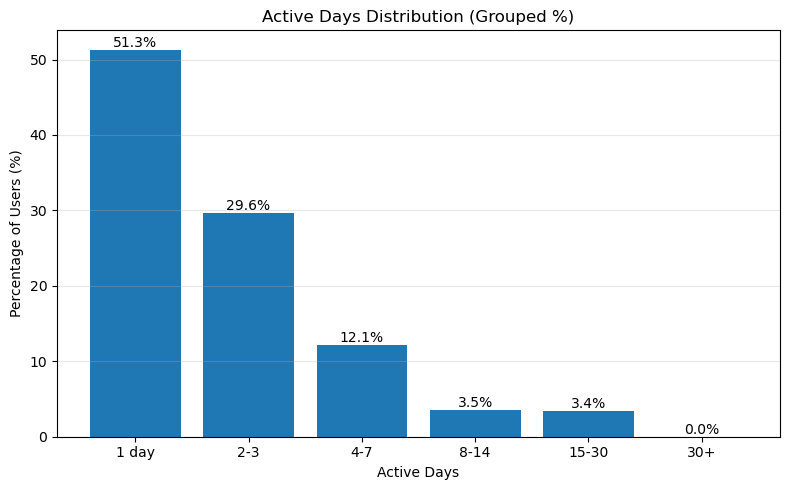

In [33]:
user_active_days_grouped = pd.cut(
    user_active_days,
    bins=[0,1,3,7,14,30,100],
    labels=["1 day","2-3","4-7","8-14","15-30","30+"]
)

distribution_pct = (
        user_active_days_grouped.value_counts(normalize=True)
        .sort_index()
        * 100
)

plt.figure(figsize=(8,5))

bars = plt.bar(distribution_pct.index, distribution_pct.values)

plt.title("Active Days Distribution (Grouped %)")
plt.xlabel("Active Days")
plt.ylabel("Percentage of Users (%)")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# Retention Analyses